In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [18]:
#get data
print("Loading MNIST dataset...")
#mnist = fetch_openml('Fashion-MNIST', version=1)
mnist = fetch_openml('mnist_784', version=1)
X,y = mnist['data'], mnist['target']

print("Encoding data...")

y = y.astype(int)
X = X/255.0

#one-hot encode labels in y
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(y).reshape(-1,1)) #y.shape = (70000, 10)
#X = X.T #Input format is n*m where m is samples, and current format is 70000*784. Changes to 784*70000


print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)




layerDims = [784,100,10] #1 hidden layer specified

print("Data loaded successfully")


Loading MNIST dataset...
Encoding data...
Splitting data...
Data loaded successfully


In [19]:
class FNN_classifier:

    def __init__(self):
        self.params = {}
    
    CONSTRAINTS = 1

    def initializeParams(self, layerDims):
        #initialize weights and biases of the network given array of dimensions of each layer
        np.random.seed(42)
        for i in range(1,len(layerDims)):
            '''
                W_i is a 2 dimensional matrix that is initialized to random values with
                dimensions n*m where n is the layers in the current dimension and
                m is the layers of the previous dimension. Each value is multiplied by 0.01
                to avoid exploding gradients. 
                The shape of the n*m matrix allows it to be multiplied in the current layer in
                forward propagation by the result of the previous layer which is an m-dimensional
                vector (Matrix mult: n*m x m*1). This results in an n dimensional vector that can then
                be taken to the next layer to repeat the process. 

                b_i is an n dimensional vector of zeros representing biases. biases don't start
                with random values like weights do. 

                Multiplication structure for a 2 by 4 weight metrix to create the linear hypothesis
                (m and n here are unrelated to previous m and n):

                [a b c d]   [i]   [m]   [o]
                [e f g h] X [j] + [n] = [p]
                            [k] 
                            [l]
            '''
            self.params['W' + str(i)] = np.random.randn(layerDims[i],layerDims[i-1])*0.1
            self.params['b' + str(i)] = np.zeros((layerDims[i],1))

        
        return self.params
    
    """
    ------------------------------------
    Activation functions
    """
    #Default value, can be changed
    activation = "relu"

    #functions return the value of the function given input Z and returns Z for caching
    def relu(self,Z):
        return np.maximum(0,Z), Z
    
    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z)), Z
    
    def tanh(self,Z):
        return np.tanh(Z), Z
    
    def softmax(self,Z):
        """
        ex. for a 3 element vector:
        Z
        """
        zexp = np.exp(Z - np.max(Z,axis=0,keepdims=True)) #Apparently this is a trick that prevents overflow
                                    #This will automatically make it so that e^largest value = e^0 = 1
                                    #This is also mathematically equivalent to regular softmax
        return zexp/np.sum(zexp, axis=0, keepdims = True), Z
    
    """
    ------------------------------------
    """
            
    def forwardProp(self,X):
        X = X.T
        #X is the incoming input matrix
        A = X
        caches = [] #stores tuples of the linear and activation caches for each layer of the network

        L = len(self.params)//2 #self.params is twice as long as the number of layers due to W_i and b_i

        for i in range(1, L+1):
            prevA = A

            #Z = Wx + b - "linear hypothesis"
            
            Z = np.dot(self.params['W' + str(i)],prevA) + self.params['b' + str(i)]

            #Caching important values from linear hypothesis
            linearCache = (prevA, self.params['W' + str(i)], self.params['b' + str(i)])

            #Caching important values from activation. Activation function returns the 
            #value of the function itself and the input Z, the result of the linear hypothesis
            
            func = 0
            if i == L: #This is the final layer, where softmax is implemented.
                func = self.softmax(Z)
                #print(f"final layer reached, softmaxed. {L}")
            elif self.activation == "relu":
                #print(f"relu'd{L}")
                func = self.relu(Z)
            elif self.activation == "sigmoid":
                func = self.sigmoid(Z)
            elif self.activation == "tanh":
                func = self.tanh(Z)
            
            A, activationCache = func

            cache = (linearCache,activationCache)
            caches.append(cache)

        return A, caches


    #Now that forward propagation is done, the loss function needs to be defined
    def crossEntropyLoss(self, yTrue, yPred):
        yTrue = yTrue.T
        """
        Computes cost function for general cross entropy loss, used for multiclass classification
        """
        #accounts for floating point inaccuracies, keeps values between 0 and 1
        yPred = np.clip(yPred, 1e-15, 1-1e-15) 

        #returns a vector of the individual sample losses
        
        losses = -np.sum(yTrue*np.log(yPred),axis=0)
        
        #Determines total cost by taking the average of the loss across the entire dataset. 
        cost = np.mean(losses)
        return cost


    #Backprop helper function that runs it for a single layer
    def stepBack(self, dA, cache, isOutput = False):
        #dA is the gradient of the loss with respect to A, dL/dA
        #unpacking cache
        linearCache, activationCache = cache
        prevA, W, b = linearCache
        Z = activationCache
        m = prevA.shape[1] #gets number of samples


        if isOutput:
            dZ = dA
        else:
            if self.activation == "relu":
                dZ = dA * (Z>0) #Interestingly enough, you can multiply numbers by booleans in python.
                #This multiplies dA by the derivative of relu which is 1 if positive and 0 if not. 
            elif self.activation == "tanh":
                dZ = dA * (1-np.tanh(Z)**2)
                #for y = tanh(x), dy/dx = 1-tanh(x)^2
            elif self.activation == "sigmoid":
                dZ = dA*self.sigmoid(Z)*(1-self.sigmoid(Z))
                #for y = sigmoid(x), dy/dx = sigmoid(x)*(1-sigmoid(x))
            else:
                raise ValueError("Activation function not supported")
        
        #Now, we can compute gradients for W, b, and prevA
        dW = (1/m)*np.dot(dZ,prevA.T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        prevdA = np.dot(W.T, dZ)

        return prevdA, dW, db
        
    #Now that the stepback function is defined for each layer going backwards, we can do backprop
    def backprop(self, AL, yPred, caches):
        grads = {}
        L = len(caches)
        
        m = AL.shape[1] 
        #Remember, AL is the final activations for every sample represented as a matrix of column vectors
        '''
        ex.      [p0a p0b p0c p0d p0e]
                 [p1a p1b p1c p1d p1e]
                 [p2a p2b p2c p2d p2e]
                 [p3a p3b p3c p3d p3e]
                 [p4a p4b p4c p4d p4e]
        Where each final letter of a term represents a different sample. AL.shape[1] returns the number of columns,
        also the number of samples. 
        '''
        yPred = yPred.T

        dAL = AL - yPred
        #Gradient of the loss function with respect to AL for general cross entropy loss.

        currentCache = caches[L-1]
        grads['dA' + str(L-1)], grads['dW' + str(L-1)], grads['db' + str(L-1)] = self.stepBack(dAL, currentCache, isOutput=True)

        for i in reversed(range(L-1)):
            currentCache = caches[i]
            prevdAtemp, dWtemp, dbtemp = self.stepBack(grads['dA' + str(i+1)], currentCache)

            grads['dA' + str(i)] = prevdAtemp
            #i+1 is used in order to match up the dA gradient used to calculate the weights and biases
            #of the following layer.
            grads['dW' + str(i)] = dWtemp
            grads['db' + str(i)] = dbtemp
#        print(grads.keys())
        return grads
    
    #Now its time for gradient descent!!! Actually updating the weights and biases according to calculated
    #grads and the learning rate, a hyperparameter.
    '''
    The learning rate hyperparameter exists to facilitate the size of steps in gradient descent. 
    If the learning rate is too small, convergence to a local minimum takes too long. 
    If the learning rate is too big, the process can overshoot and diverge, not reaching the minimum.
    '''
    #Also, we don't know when a minimum is reached, we just try to get close. More epochs exist to try
    #and approach the minimum of the cost function. 
    '''
    Many optimizers use dynamic learning rates, decreasing step size as a minimum seems to be approached
    to get a more accurate estimate without overshooting.
    '''
    def updateParameters(self, grads, learningRate):
        L = len(self.params) // 2 #layer number

#        print(L)
        for i in range(L):
            #starting with first hidden layer updating current Weights

            



            #---------^^------------------

            self.params['W'+str(i+1)] = self.params['W'+str(i+1)] - learningRate*grads['dW'+str(i)]
            #then biases
            self.params['b'+str(i+1)] = self.params['b'+str(i+1)] - learningRate*grads['db'+str(i)]

            '''
            W_new = W - lr*grad_b
            b_new = b - lr*grad_b

            What it looks like to me is a steeper negative gradient will increase a weight ot a bias
            while a positive gradient value decreases the weight or the bias.

            A positive gradient means that increasing that parameter would increase the cost
            (if we consider partial derivative of the cost function with respect to weights or biases),
            so we decrease a weight associated with a positive gradient. Negative gradients decrease the cost
            so we increase those weights to emphasize them more.
            '''


        #implements the weight device constraints. 
        #R_on/R_off = 10
        #4 bit states: total number of states = 16
        #HARDWARE IN THE LOOP TRAINING
        """
        for i in range(L):
            pct = np.percentile(self.params['W'+str(i+1)],98)
            Wpos = np.where(self.params['W'+str(i+1)] > 0, np.maximum(np.minimum(self.params['W'+str(i+1)], pct), pct/10), self.params['W'+str(i+1)])
            self.params['W'+str(i+1)] = np.where(Wpos < 0, np.minimum(np.maximum(Wpos, -pct), -pct/10), Wpos)
            Ws = self.params['W'+str(i+1)]
            Wq = np.sign(Ws) * np.round(np.abs(Ws) / np.max(np.abs(Ws)) * 15) * (np.max(np.abs(Ws)) / 15)
            
            self.params['W'+str(i+1)] = Wq
        """

    #Now the function must be trained.
    X_TEST = None
    Y_TEST = None
    accHistory = []
    def train(self, X, y, layerDims, epochs, learningRate):

        params = self.initializeParams(layerDims)
        costHistory = []

        for i in range(epochs):
            Y_hat, caches = self.forwardProp(X)
            cost = self.crossEntropyLoss(Y_hat,y)
            costHistory.append(cost)
            grads = self.backprop(Y_hat, y, caches)

            params = self.updateParameters(grads, learningRate)
            
            accuracy = np.mean(self.predict(FNN_classifier.X_TEST) == np.argmax(FNN_classifier.Y_TEST, axis=1))
            self.accHistory.append(accuracy)
            if i%10 == 0:
                print(f"Epoch {i}: Accuracy = {accuracy * 100:.2f}%")
            
        return params, costHistory
    



    def predict(self, X):

        if FNN_classifier.CONSTRAINTS:
            
            L = len(self.params)//2
            buffered_params = self.params.copy()
            #Saves the previous state of self.params in buffered_params and then implements the weight device constraints. 
            #R_on/R_off = 10
            #4 bit states: total number of states = 16
            
            for i in range(L):
                pct = np.percentile(self.params['W'+str(i+1)],98)
                Wpos = np.where(self.params['W'+str(i+1)] > 0, np.maximum(np.minimum(self.params['W'+str(i+1)], pct), pct/10), self.params['W'+str(i+1)])
                self.params['W'+str(i+1)] = np.where(Wpos < 0, np.minimum(np.maximum(Wpos, -pct), -pct/10), Wpos)
                Ws = self.params['W'+str(i+1)]
                Wq = np.sign(Ws) * np.round(np.abs(Ws) / np.max(np.abs(Ws)) * 1) * (np.max(np.abs(Ws)) / 1) # Bit discretization. Scales to 0-1 then remultiplies.
                
                self.params['W'+str(i+1)] = Wq
                



        A, _ = self.forwardProp(X)

        
        
        if FNN_classifier.CONSTRAINTS:
            for i in range(L):
                self.params['W'+str(i+1)] = buffered_params['W'+str(i+1)]
        
        
        
#        print(A.shape)
        return np.argmax(A, axis=0) #return highest probability index

    #My self-designed optimizer program inspired from RMS-prop.
    def updateLR(self, i, epochs, accSlopes, learningRate):
        first = (accSlopes[0]+accSlopes[1]+accSlopes[2])/3
        #After a certain point, starts using previous slope history to compare
        if len(accSlopes) >= epochs/2 and len(accSlopes) > 21:
            prevSlopeAvg = 0
            for j in range(11,21):
                prevSlopeAvg += accSlopes[i-j]
            prevSlopeAvg /= 10

        if first < 0:
            first = 0 - first
        lr = learningRate
        recentSlopeAvg = accSlopes[-1]
        if len(accSlopes) > 21:
            recentSlopeAvg = 0
            for j in range(1,11):
                recentSlopeAvg += accSlopes[i-j]
            recentSlopeAvg /= 10
        

        #For index errors, stops before last epoch. 
        if epochs > 0 and i < epochs:
            if recentSlopeAvg < first and recentSlopeAvg > 0:
                #decrease the learning rate proportionally to the derivative decrease but within limits 0.75 to 1. 
                if len(accSlopes) >= epochs/2 and len(accSlopes) > 9:
                    changeFactor = (1000*recentSlopeAvg)/(1000*prevSlopeAvg)
                else: 
                    changeFactor = recentSlopeAvg/first
                
                #print(f"{changeFactor}went down")
                if changeFactor < 0.985:
                    changeFactor = 0.985
                if changeFactor > 1:
                    changeFactor = 1
                lr *= changeFactor
            if recentSlopeAvg < 0:
                cslope = 0 - recentSlopeAvg
                if len(accSlopes) >= epochs/2 and len(accSlopes) > 9:
                    changeFactor = (1000*max(cslope,prevSlopeAvg))/(1000*min(cslope,prevSlopeAvg))
                else:
                    changeFactor = max(cslope,first)/min(cslope,first) #ensures >1 value
                #print(f"{changeFactor}went up")
                if changeFactor < 1:
                    changeFactor = 1
                if changeFactor > 1.12:
                    changeFactor = 1.12
                lr *= changeFactor
            #to avoid overfitting, randomly spikes learning rate when it's below a certain value.
            if lr < 0.4 and ((np.random.randint(0,10) & 1 == 1)):
                lr *= 4
            if lr > 1.3:
                lr = 1.3
        return lr
        buffered_params = self.params.copy()


    '''
    Changes to make:
    - Implement L2 regularization
    - Implement dropout
    - Implement batch normalization
    - Implement momentum
    - Create an optimizer system to dynamically change the learning rate
    - Implement mini-batch gradient descent
    - Number display
    '''


In [20]:
print("Training neural network...")

network = FNN_classifier()
network.activation = "relu" #relu, tanh, sigmoid are available
FNN_classifier.X_TEST = X_test
FNN_classifier.Y_TEST = y_test

epochs = 1000
learningRate = 1.2

params, costHistory = network.train(X_train, y_train, layerDims, epochs, learningRate)


Training neural network...
Epoch 0: Accuracy = 25.76%
Epoch 10: Accuracy = 56.49%
Epoch 20: Accuracy = 58.15%
Epoch 30: Accuracy = 71.84%
Epoch 40: Accuracy = 76.44%
Epoch 50: Accuracy = 79.74%
Epoch 60: Accuracy = 80.52%
Epoch 70: Accuracy = 81.26%
Epoch 80: Accuracy = 80.21%
Epoch 90: Accuracy = 82.75%
Epoch 100: Accuracy = 84.54%
Epoch 110: Accuracy = 83.55%
Epoch 120: Accuracy = 84.29%
Epoch 130: Accuracy = 84.39%
Epoch 140: Accuracy = 84.93%
Epoch 150: Accuracy = 84.54%
Epoch 160: Accuracy = 84.14%
Epoch 170: Accuracy = 84.04%
Epoch 180: Accuracy = 84.85%
Epoch 190: Accuracy = 83.76%
Epoch 200: Accuracy = 80.95%
Epoch 210: Accuracy = 81.56%
Epoch 220: Accuracy = 83.30%
Epoch 230: Accuracy = 83.11%
Epoch 240: Accuracy = 83.05%
Epoch 250: Accuracy = 83.63%
Epoch 260: Accuracy = 83.23%
Epoch 270: Accuracy = 82.84%
Epoch 280: Accuracy = 82.33%
Epoch 290: Accuracy = 81.79%
Epoch 300: Accuracy = 83.09%
Epoch 310: Accuracy = 83.64%
Epoch 320: Accuracy = 83.62%
Epoch 330: Accuracy = 84.09

In [21]:
print("Calculating final accuracy and graphing accuracy and cost histories...")
yPred = network.predict(X_test)

#    print("Unique classes predicted:", np.unique(yPred))
print("First few predictions:\t", yPred[:35])
print("Expected labels:\t", np.argmax(y_test, axis=1)[:35])
#    print(yPred.shape)
#    print(y_test.shape)
accuracy = np.mean(yPred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Final Cost: {costHistory[-1]}")


Calculating final accuracy and graphing accuracy and cost histories...
First few predictions:	 [0 4 9 2 9 0 2 6 4 4 1 2 9 3 2 2 1 4 2 6 0 3 4 1 4 1 9 9 4 3 3 8 4 9 3]
Expected labels:	 [0 4 0 2 0 0 2 6 0 4 1 2 7 3 2 2 1 7 2 6 0 3 7 1 4 1 9 7 4 8 7 8 4 0 3]
Accuracy: 83.0714%
Final Cost: 5563.5090438243105


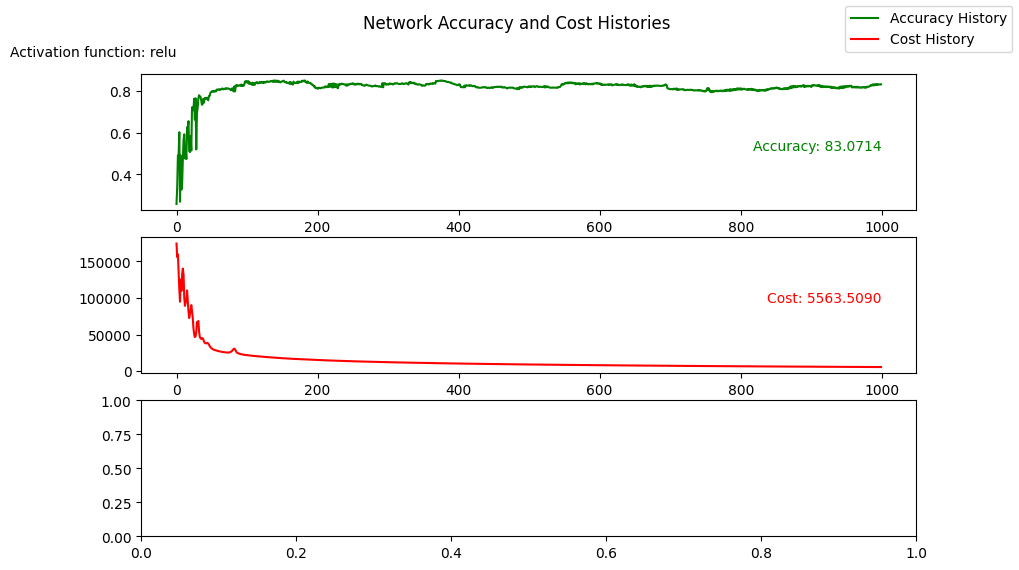

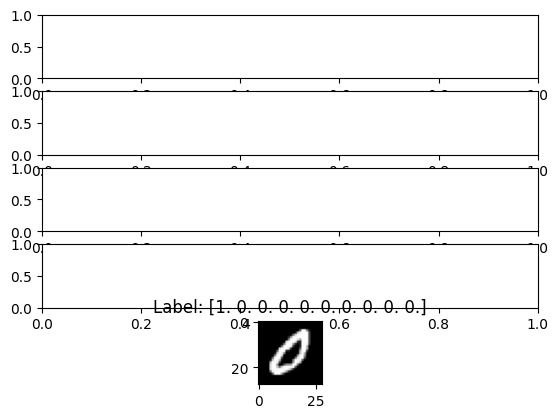

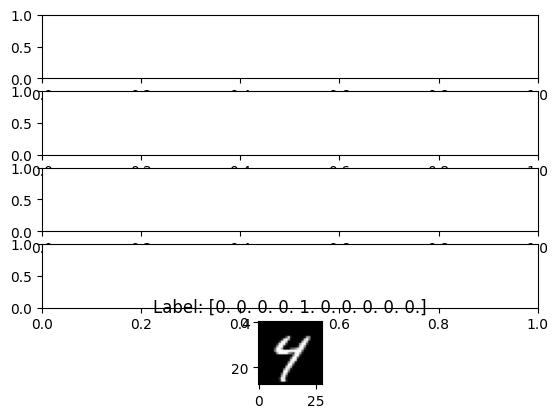

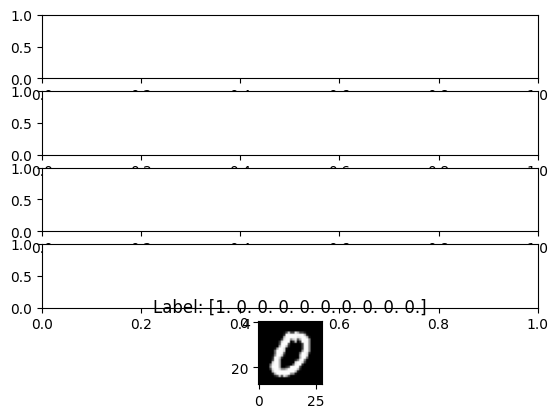

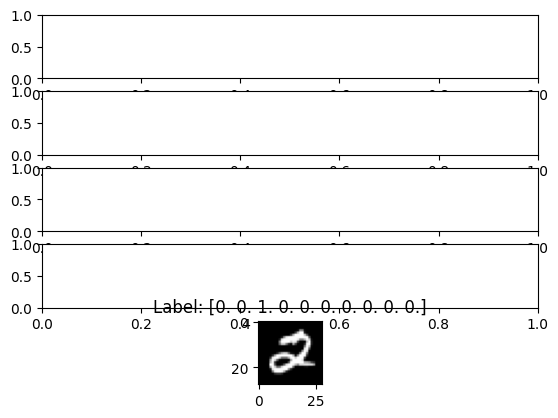

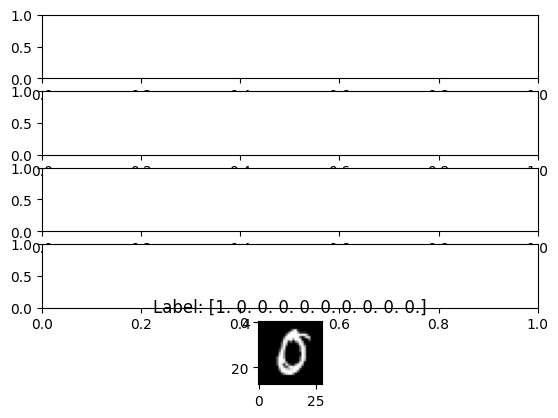

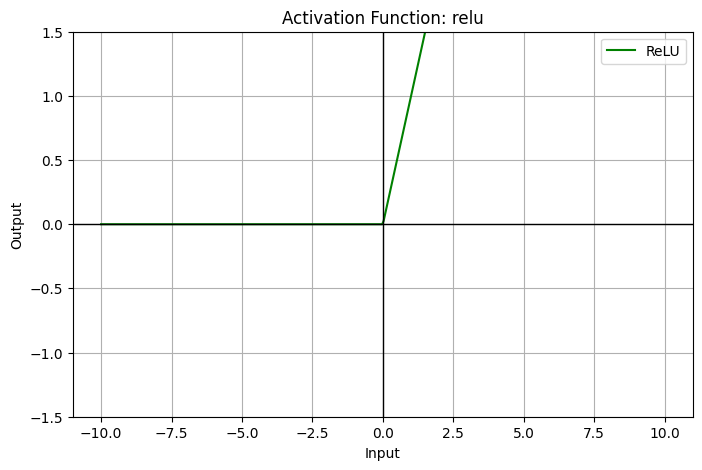

In [22]:
#Make plots to display mnist numbers and plot cost history

fig,axs = plt.subplots(3)
fig.suptitle('Network Accuracy and Cost Histories')
axs[0].plot(network.accHistory, label = 'Accuracy History', color = 'green')
axs[0].text(epochs, 0.5, f'Accuracy: {accuracy*100:.4f}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='green')
axs[0].text(0, max(network.accHistory) + 0.1, f'Activation function: {network.activation}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')
axs[1].plot(costHistory, label = 'Cost History', color = 'red')
axs[1].text(epochs, (max(costHistory)-min(costHistory))/2+min(costHistory), f'Cost: {costHistory[-1]:.4f}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='red')
#axs[2].plot(network.lrHist, label = 'LR History', color = 'green')
fig.legend()
fig.set_figheight(6)
fig.set_figwidth(10)

#display mnist digits - WIP
for i in range(5):
    import matplotlib.pyplot as plt2
    fig2, axs2 = plt2.subplots(5)
    plt2.imshow(X_test.to_numpy()[i].reshape(28,28), cmap='gray')
    plt2.title(f'Label: {y_test[i]}')
plt2.show()
plt.show()


#plot activation function
x = np.linspace(-10,10,400)
sig = network.sigmoid(x)[0]
tanh = np.tanh(x)
relu = np.maximum(0,x)

#plot
import matplotlib.pyplot as plt3
plt3.figure(figsize=(8, 5))
if network.activation == "sigmoid":
    plt3.plot(x, sig, label = 'Sigmoid', color = 'blue')
if network.activation == "tanh":
    plt3.plot(x, tanh, label = 'Tanh', color = 'red')
if network.activation == "relu":
    plt3.plot(x, relu, label="ReLU", color = 'green')
plt3.title("Activation Function: " + network.activation)
plt3.xlabel("Input")
plt3.ylabel("Output")
plt3.grid(True)
plt3.ylim(-1.5,1.5)
plt3.axhline(0, color='black', linewidth=1)
plt3.axvline(0, color='black', linewidth=1)
plt3.legend()
plt3.show()